In [1]:
import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D


%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


## Data Loading and Preparation

In [2]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [3]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000] #these are the 20k with the HIGHEST READ COUNT
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

label_e_train = e_train['scaled_rl']
label_e_test = e_test['rl']

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Calculate / Load MFE Calculations for All Data Points

In [4]:
get_mfe = lambda s: RNA.fold(s)[1]
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"

def get_start_subseq(utr,n_bp=75):
    seq = upstream_constant+utr+eGFP+downstream_addition
    return seq[:min(n_bp,len(seq))]

In [5]:
# data = pd.DataFrame([df['utr'],df['rl']]).transpose()

# data['scaled_rl'] = preprocessing.StandardScaler().fit_transform(data['rl'].values.reshape(-1,1))
# print 'finished rescale'
# data['mfe75'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,75))) #just constant region + random region
# print 'finished 75'
# data['mfe100'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,100)))
# print 'finished 100'
# data['mfe125'] = data['utr'].apply(lambda s: get_mfe(get_start_subseq(s,125)))
# print 'finished 125'

# data.to_csv('../mfe_dataset.csv')

data = pd.read_csv('../mfe_dataset.csv',index_col=0)
data.head(2)

,utr,rl,scaled_rl,mfe75,mfe100,mfe125
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.039939,-2.130922,-16.0,-24.700001,-34.799999
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.895109,-1.600332,-14.4,-25.600000,-36.400002


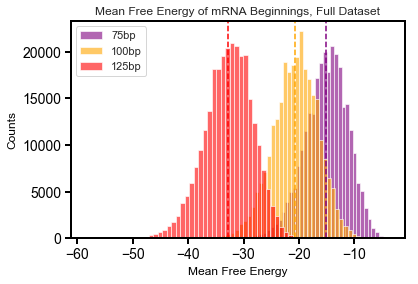

In [6]:
# Display MFE Distributions
fig,ax = plt.subplots()
ax.hist(data['mfe75'].values,color='purple',bins=50,alpha=0.6,label='75bp')
ax.axvline(np.mean(data['mfe75'].values),color='purple',linestyle="--")
ax.hist(data['mfe100'].values,color='orange',bins=50,alpha=0.6,label='100bp')
ax.axvline(np.mean(data['mfe100'].values),color='orange',linestyle="--")
ax.hist(data['mfe125'].values,color='red',bins=50,alpha=0.6,label='125bp')
ax.axvline(np.mean(data['mfe125'].values),color='red',linestyle="--")
ax.set_title("Mean Free Energy of mRNA Beginnings, Full Dataset")
ax.set_xlabel('Mean Free Energy')
ax.set_ylabel("Counts")
ax.legend()

## Start with Author's Model

In [7]:
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5')

W0918 14:28:14.114147 4652307904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 14:28:14.134265 4652307904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 14:28:14.137604 4652307904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 14:28:14.245776 4652307904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0918 14:28:14.260013 4652307904 deprecati

## What happens if we visualize model performance on ALL the data, not just the test set?

In [8]:
# Test Dataset
e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test,output_col='auth_pred')
r = r2(e_test['rl'], e_test['auth_pred'])
print 'r-squared = ', r

r-squared =  0.9338504476208073


In [9]:
# Train Dataset
e_train = test_data(df=e_train, model=model, obs_col='rl', test_seq=seq_e_train,output_col='auth_pred')
r = r2(e_train['rl'], e_train['auth_pred'])
print 'r-squared = ', r

r-squared =  0.8941933452903729


In [10]:
# Entire Dataset
seq_data = one_hot_encode(data,seq_len=50)
data = test_data(df=data, model=model, obs_col='rl',test_seq=seq_data,output_col='auth_pred')
r = r2(data['rl'], data['auth_pred'])
print 'r-squared = ', r

r-squared =  0.8996725996764278


In [12]:
data[data['utr'] == 'CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT']

,utr,rl,scaled_rl,mfe75,mfe100,mfe125,auth_pred
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,3.895109,-1.600332,-14.4,-25.6,-36.400002,4.013478


In [13]:
e_test[e_test['utr'] == 'CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT']

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r6,r7,r8,r9,r10,r11,r12,r13,rl,auth_pred
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,0.000067,0.00007,0.000065,0.000048,0.000023,0.00002,0.000011,0.000011,...,0.02854,0.027431,0.024766,0.024241,0.039457,0.039457,0.03984,0.038785,3.895109,2.899773


# Why are these different? ^^

In [16]:
# Make Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

Train is blue, Test is red


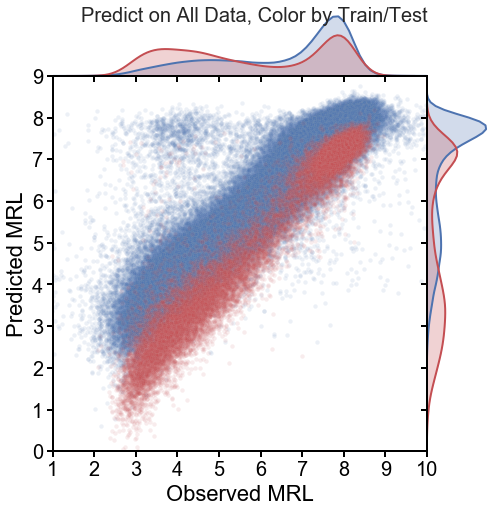

In [18]:
train_test_plot = jointgrid_plot([e_train,
                                  e_test],
                                 title='Predict on All Data, Color by Train/Test',yheader='auth_pred')
print "Train is blue, Test is red"

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Train is blue, Test is red


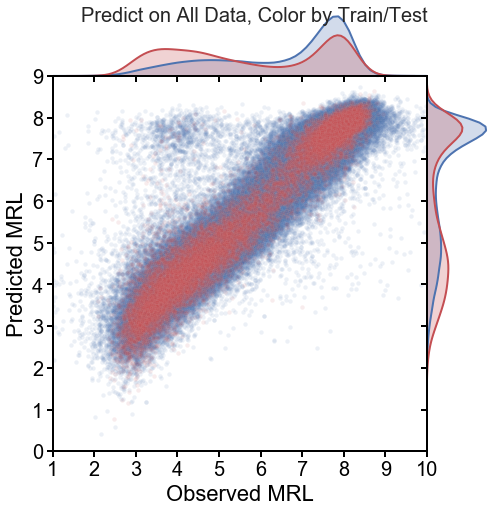

In [17]:
# Visualize Model performance on Test vs Train Datasets
train_test_plot = jointgrid_plot([data[data['utr'].isin(e_train['utr'])],
                                  data[data['utr'].isin(e_test['utr'])]],
                                 title='Predict on All Data, Color by Train/Test',yheader='auth_pred')
print "Train is blue, Test is red"

Wow, the model does way better on the test set than the train set! Also, the upper off-diagonal cluster is much more pronounced when including the train set

In [10]:
# Try to isolate that off-diagonal "cluster" of low observed/high predicted MRL
od_cluster = data[((data['pred']-data['rl'])**2 > 3.5)
                  &(data['pred']-data['rl'] > 0)
                  &(data['pred'] > 6.5)] 
len(od_cluster)

KeyError: 'pred'

In [9]:
rest_of_data = data[~data['utr'].isin(od_cluster['utr'].values)]
od_plot = jointgrid_plot([rest_of_data,od_cluster],colors=['orange','purple'],yheader='pred',
               title="Show Off-Diagonal Partition",alphas=[0.1,0.3])

NameError: name 'od_cluster' is not defined

In [15]:
d = df[df['utr'].isin(od_cluster['utr'].values)]
print np.mean(d['total_reads']), "\t",'full dataset off-diagonal average read count'
print np.mean(e_test['total_reads']), "\t\t",'test dataset average read count'
print np.mean(e_train['total_reads']), "\t\t", 'train dataset average read count'
print np.mean(e_test[e_test['utr'].isin(od_cluster['utr'].values)]['total_reads']),"\t", 'test dataset off-diagonal average read count'
print
print "Okay, off-diagonals are NOT there just for lack of reads, even if they have slighly fewer on average. Good to know."

971.5691699604743 	full dataset off-diagonal average read count
3185.96415 		test dataset average read count
1070.73505 		train dataset average read count
3098.3396226415093 	test dataset off-diagonal average read count

Okay, off-diagonals are NOT there just for lack of reads, even if they have slighly fewer on average. Good to know.


### So, what's special about these points?  Hmm...

In [16]:
# Save off-diagonal cluster points
# od_cluster.to_csv('./saved_data/off_diagonal_cluster/CNN_auth_total_od.csv')

### Can I color that same plot by stratified MFE?

Maybe the off-diagonal cluster has more secondary structure, and the model doesn't handle it well?

In [17]:
# Optionally Color by Custom Stratifications (rather than quartile splits, seen below)
# blue_mfe = data[data['mfe125'] > -30]
# green_mfe = data[(data['mfe125'] < -30) & (data['mfe125'] > -35)]
# orange_mfe = data[(data['mfe125'] < -35) & (data['mfe125'] >= -40)]
# red_mfe = data[data['mfe125'] < -40]

# print "Blue:", len(blue_mfe)
# print "Green:", len(green_mfe)
# print "Orange:", len(orange_mfe)
# print "Red:", len(red_mfe)

# mfe125_plot = jointgrid_plot([blue_mfe,green_mfe,orange_mfe,red_mfe],
#                             colors=['blue','green','orange','red'],
#                             alphas=[0.1,0.05,0.05,0.1],
#                             title="MFE, 125bp")

# Train Models on Stratified MFE

Start by splitting the dataset in a rational way

In [ ]:
# Stratify based on the 100bp MFE 
data.sort_values('mfe100',inplace=True,ascending=False)
data.reset_index(inplace=True,drop=True)

highest_qt = data.iloc[:70000] #these have the least negative/highest MFE => least 2ndary structure
nexthigh_qt = data.iloc[70000:140000]
nextlow_qt = data.iloc[140000:210000]
lowest_qt = data.iloc[210000:] #these have the lowest MFE => highest 2ndary structure

high_half = data.iloc[:140000]
low_half = data.iloc[140000:]

In [ ]:
# Visualize
d,c = [highest_qt,nexthigh_qt,nextlow_qt,lowest_qt],['blue','green','orange','red']
mfe100_plot = jointgrid_plot(d,colors=c,alphas=[0.05,0.05,0.05,0.05],title="MFE, 100bp")

## Construct Model

Use a smaller model (because we know that 120f is too big anyway), but more epochs due to the smaller dataset size. Also we can try to add in beneficial modifications we saw from previous experiments

In [20]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dilation1=3, dilation2=1, dilation3=1, 
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), dilation_rate=dilation1,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation2,
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), dilation_rate=dilation3, 
                         padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model

In [21]:
# Shuffle the datasets before splitting between train and test
np.random.seed(1337)
high_half.sample(frac=1).reset_index(drop=True)
low_half.sample(frac=1).reset_index(drop=True)

high_train = high_half.iloc[:120000]
high_test = high_half.iloc[120000:]
low_train = low_half.iloc[:120000]
low_test = low_half.iloc[120000:]

seq_high_train = one_hot_encode(high_train,seq_len=50)
seq_low_train = one_hot_encode(low_train, seq_len=50)
seq_high_test = one_hot_encode(high_test,seq_len=50)
seq_low_test = one_hot_encode(low_test, seq_len=50)

seq_ods_test = one_hot_encode(od_cluster, seq_len=50)

In [33]:
# Load Models
high_model = keras.models.load_model('./saved_models//cnn_model_40f16bp5e_highMFE.hdf5')
low_model = keras.models.load_model('./saved_models/cnn_model_40f16bp5e_lowMFE.hdf5')

#### High MFE Model

In [23]:
# np.random.seed(1337)
# high_model = train_model(seq_high_train, high_train['scaled_rl'], nb_epoch=5, border_mode='same',
#                     inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=16,
#                     dilation1=1, dilation2=4,
#                     dropout1=0, dropout2=0,dropout3=0.2)

In [35]:
high_test = test_data(df=high_test, model=high_model, obs_col='rl',test_seq=seq_high_test,output_col='high_pred')
r = r2(high_test['rl'], high_test['high_pred']) 
print 'high model/high mfe r-squared = ', r

high model/high mfe r-squared =  0.8915229938861907


In [36]:
low_test = test_data(df=low_test, model=high_model, obs_col='rl',test_seq=seq_low_test,output_col='high_pred')
r = r2(low_test['rl'], low_test['high_pred']) 
print 'high model/low mfe r-squared = ', r

high model/low mfe r-squared =  0.8341743421352477


In [37]:
# just how bad is it on the off-diagonal not-well-predicted utrs?
od_cluster = test_data(df=od_cluster, model=high_model, obs_col='rl',test_seq=seq_ods_test,output_col='high_pred')
r = r2(od_cluster['rl'], od_cluster['high_pred']) 
print 'high model/off-diagonal cluster r-squared = ', r

high model/off-diagonal cluster r-squared =  0.009434619627520536


#### Low MFE Model

In [46]:
np.random.seed(1337)
low_model = train_model(seq_low_train, low_train['scaled_rl'], nb_epoch=5, border_mode='same',
                    inp_len=50, nodes=40, layers=3, nbr_filters=40, filter_len=16,
                    dilation1=1, dilation2=4,
                    dropout1=0, dropout2=0,dropout3=0.2)

Epoch 1/5
120000/120000 [==============================] - 40s 335us/step - loss: 0.3996
Epoch 2/5
120000/120000 [==============================] - 41s 339us/step - loss: 0.1725
Epoch 3/5
120000/120000 [==============================] - 35s 291us/step - loss: 0.1364
Epoch 4/5
120000/120000 [==============================] - 34s 279us/step - loss: 0.1265
Epoch 5/5
120000/120000 [==============================] - 33s 274us/step - loss: 0.1207


In [47]:
high_test = test_data(df=high_test, model=low_model, obs_col='rl',test_seq=seq_high_test,output_col='low_pred')
r = r2(high_test['rl'], high_test['low_pred']) 
print 'low model/high mfe r-squared = ', r

low model/high mfe r-squared =  0.8875715003727738


In [48]:
low_test = test_data(df=low_test, model=low_model, obs_col='rl',test_seq=seq_low_test,output_col='low_pred')
r = r2(low_test['rl'], low_test['low_pred']) 
print 'low model/low mfe r-squared = ', r

low model/low mfe r-squared =  0.8418900174815311


In [49]:
od_cluster = test_data(df=od_cluster, model=low_model, obs_col='rl',test_seq=seq_ods_test,output_col='low_pred')
r = r2(od_cluster['rl'], od_cluster['low_pred']) 
print 'low model/off-diagonal cluster r-squared = ', r

low model/off-diagonal cluster r-squared =  0.0186073496443234


#### Test both models on lowest MFE quartile of sequences

In [50]:
# Try testing on just the lowest-MFE global quartile of sequences (most structure)
seq_lowest_test = one_hot_encode(lowest_qt,seq_len=50)
seq_highest_test = one_hot_encode(highest_qt,seq_len=50)

lowest_test = test_data(df=lowest_qt, model=high_model, obs_col='rl',test_seq=seq_lowest_test,output_col='high_pred')
r = r2(lowest_test['rl'], lowest_test['high_pred']) #not sure why typecast is needed?
print 'high model/lowest quartile mfe r-squared = ', r

high model/lowest quartile mfe r-squared =  0.8618120713051841


In [51]:
lowest_test = test_data(df=lowest_qt, model=low_model, obs_col='rl',test_seq=seq_lowest_test,output_col='low_pred')
r = r2(lowest_test['rl'].astype('float'), lowest_test['low_pred'].astype('float')) #not sure why typecast is needed?
print 'low model/lowest quartile mfe r-squared = ', r

low model/lowest quartile mfe r-squared =  0.8774662170594595


In [54]:
# # Save Models
# high_model.save('./saved_models/cnn_model_40f16bp5e_highMFE.hdf5')
# low_model.save('./saved_models/cnn_model_40f16bp5e_lowMFE.hdf5')

In [61]:
e_train = test_data(df=e_train, model=high_model, obs_col='rl',test_seq=seq_e_train,output_col='high_pred')
r = r2(e_train['rl'], e_train['high_pred'])
print r
e_train = test_data(df=e_train, model=low_model, obs_col='rl',test_seq=seq_e_train,output_col='low_pred')
r = r2(e_train['rl'], e_train['low_pred'])
print r

0.886944899000055
0.8854515597886354


In [62]:
e_test = test_data(df=e_test, model=high_model, obs_col='rl',test_seq=seq_e_test,output_col='high_pred')
r = r2(e_test['rl'], e_test['high_pred'])
print r
e_test = test_data(df=e_test, model=low_model, obs_col='rl',test_seq=seq_e_test,output_col='low_pred')
r = r2(e_test['rl'], e_test['low_pred'])
print r

0.9362798778666594
0.9344773260178375


In [117]:
high_set = set(high_ods['utr'].values)
low_set = set(low_ods['utr'].values)
auth_set = set(auth_ods['utr'].values)

In [14]:
comp1 = jointgrid_plot([n[~n['utr'].isin(auth_set)],n[n['utr'].isin(auth_set)]],yheader='pred')

NameError: name 'jointgrid_plot' is not defined

Text(0.5,0.98,'Testing High- and Low-Trained Models Against Off-Diagonal Cluster')

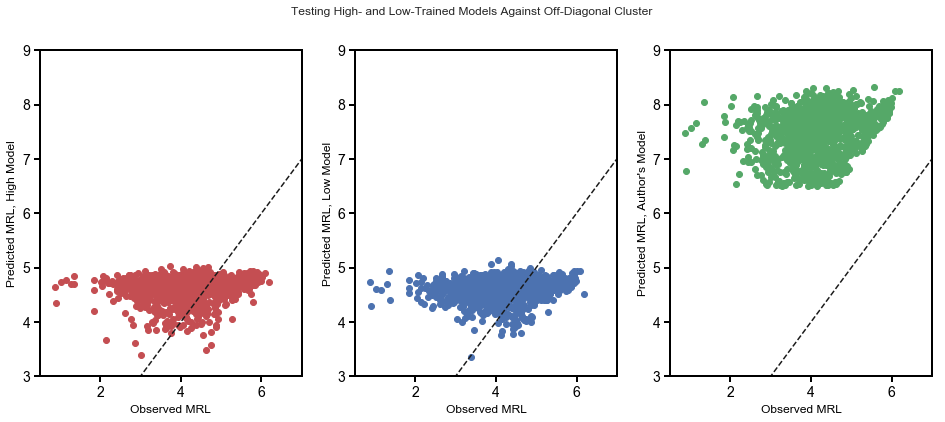

In [90]:
f,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
ax1.scatter(ods['rl'],ods['high_pred'],color='r')
ax2.scatter(ods['rl'],ods['low_pred'],color='b')
ax3.scatter(ods['rl'],ods['pred'],color='g')
ax1.plot(range(10),range(10),color='k',linestyle="--")
ax2.plot(range(10),range(10),color='k',linestyle="--")
ax3.plot(range(10),range(10),color='k',linestyle="--")
ax1.set_xlabel("Observed MRL")
ax2.set_xlabel("Observed MRL")
ax3.set_xlabel("Observed MRL")
ax1.set_ylabel("Predicted MRL, High Model")
ax2.set_ylabel("Predicted MRL, Low Model")
ax3.set_ylabel("Predicted MRL, Author's Model")
ax1.set_xlim(0.5,7.01)
ax2.set_xlim(0.5,7.01)
ax3.set_xlim(0.5,7.01)
ax1.set_ylim(3,9)
ax2.set_ylim(3,9)
ax3.set_ylim(3,9)
f.suptitle("Testing High- and Low-Trained Models Against Off-Diagonal Cluster")

### What is going on here? Why is the R2 better for the author's model than the high and low models, when the clusters are in super different places?

# Analyze 2ndary Structure of Off-Diagonal Sequences

Prediction: they have more structure, statistically, than on-diagonal sequences

In [150]:
# "pred" is the predictions from the model 'main_CNN_model.hdf5'
print len(ods)
ods.head()

1276


,Unnamed: 0.1,utr,rl,scaled_rl,mfe75,mfe100,mfe125,pred
292,292,CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA,4.654325,-1.129277,-14.000000,-19.000000,-33.700001,7.726174
809,809,ATCGATCCACCCTGCATAGCAGGGAACTCTATTGTGCATGTTCGGATGCG,3.331041,-1.950308,-21.600000,-28.200001,-38.500000,6.763197
999,999,AGCTTACTGAACCTGGTCGTGGAGGTATGCAGGAGGTATGTGCATGCCTG,4.065457,-1.494640,-17.799999,-29.400000,-37.200001,6.719247
1046,1046,GCGAGGGAACAAGAGCAAAGGAGAATCTAGGCCACATCTCTCGTCGTTCC,4.038996,-1.511058,-16.000000,-20.799999,-32.000000,7.865101
1550,1550,CCCGACAATACTAGTGCTTTTAGGTATACACGCATAGTATGTTAACTGGT,5.111562,-0.845585,-11.300000,-16.799999,-29.600000,8.160692


## 75 bp

In [147]:
test75_values = ods['mfe75'].values
test75_mean = np.mean(test75_values)
test75_std = np.std(test75_values)
print "mean:", test75_mean, "std:", test75_std

mean: -15.04945144458998 std: 4.11644284078447


Text(0.5,1,'Mean Free Energy of All Off-Diagonals, 75 bp')

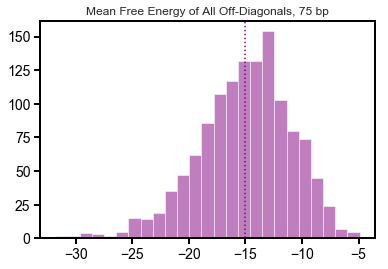

In [148]:
fig,ax = plt.subplots()
ax.hist(test75_values,color='purple',bins=25,alpha=0.5)
ax.axvline(test75_mean,color='purple',linestyle=":")
ax.set_title("Mean Free Energy of All Off-Diagonals, 75 bp")

In [151]:
pop75_means = np.zeros(10000)
pop75_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe75'].values
    pop75_means[i],pop75_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -15.04945144458998
Population mean: -15.040842965043842


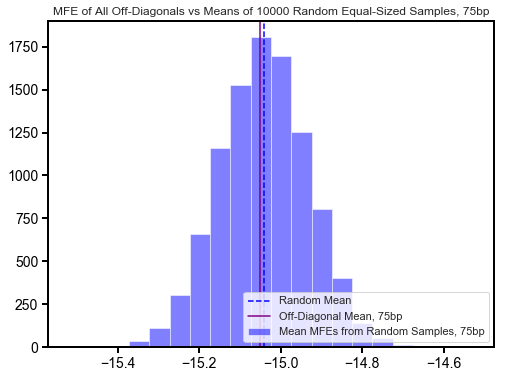

In [152]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop75_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 75bp')
ax.axvline(np.mean(pop75_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test75_mean,color='purple',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 10000 Random Equal-Sized Samples, 75bp")
ax.legend(loc='lower right')
print "Sample mean:", test75_mean
print "Population mean:", np.mean(pop75_means)

In [160]:
count_more_extreme75 = np.count_nonzero(pop75_means < test75_mean)
print count_more_extreme75
n = (1-(count_more_extreme75/10000.0))*100
print "The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


4691
The mean MFE of the first 75 bp of the 6155 total off-diagonal sequences is lower than 53.09 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 100 bp

mean: -20.74801722140895 std: 4.203270369545972


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 100 bp')

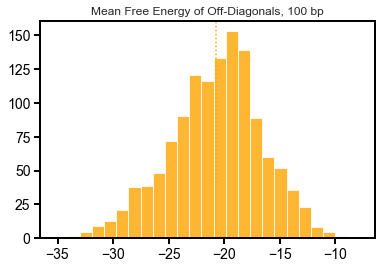

In [154]:
test100_values = ods['mfe100'].values
test100_mean = np.mean(test100_values)
test100_std = np.std(test100_values)
print "mean:", test100_mean, "std:", test100_std
fig,ax = plt.subplots()
ax.hist(test100_values,color='orange',bins=25,alpha=0.8)
ax.axvline(test100_mean,color='orange',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 100 bp")

In [155]:
pop100_means = np.zeros(10000)
pop100_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe100'].values
    pop100_means[i],pop100_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -20.74801722140895
Population mean: -20.61178055969372


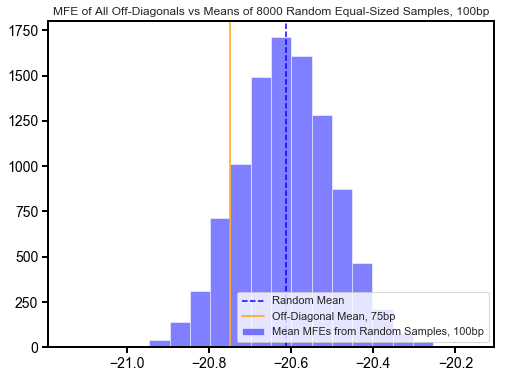

In [156]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop100_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 100bp')
ax.axvline(np.mean(pop100_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test100_mean,color='orange',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 100bp")
ax.legend(loc='lower right')
print "Sample mean:", test100_mean
print "Population mean:", np.mean(pop100_means)

In [161]:
count_more_extreme100 = np.count_nonzero(pop100_means < test100_mean)
print count_more_extreme100
n = (1-(count_more_extreme100/10000.0))*100
print "The mean MFE of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


1214
The mean MFE of the 6155 total off-diagonal sequences is lower than 87.86 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


## 125 bp

mean: -32.79858937009375 std: 4.420789914304064


Text(0.5,1,'Mean Free Energy of Off-Diagonals, 125 bp')

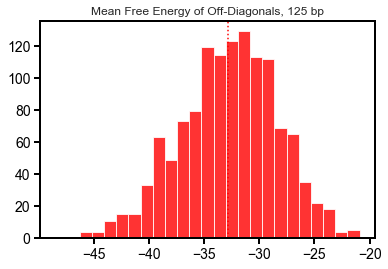

In [162]:
test125_values = ods['mfe125'].values
test125_mean = np.mean(test125_values)
test125_std = np.std(test125_values)
print "mean:", test125_mean, "std:", test125_std
fig,ax = plt.subplots()
ax.hist(test125_values,color='red',bins=25,alpha=0.8)
ax.axvline(test125_mean,color='red',linestyle=":")
ax.set_title("Mean Free Energy of Off-Diagonals, 125 bp")

In [163]:
pop125_means = np.zeros(10000)
pop125_stds = np.zeros(10000)

np.random.seed(1337)
for i in range(10000):
     #pick 45 rows from test dataset at random
    indices = np.random.choice(range(len(data)),len(ods))
    mfes = data.iloc[indices]['mfe125'].values
    pop125_means[i],pop125_stds[i] = np.mean(mfes),np.std(mfes)
    if (i+1) % 1000 == 0:
        print i+1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


Sample mean: -32.79858937009375
Population mean: -32.718525249751906


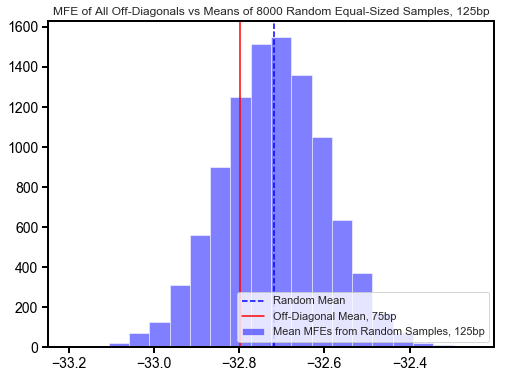

In [164]:
fig,ax = plt.subplots(figsize=(8,6))
ax.hist(pop125_means,color='blue',alpha=0.5,bins=20,label='Mean MFEs from Random Samples, 125bp')
ax.axvline(np.mean(pop125_means),linestyle='--',color='blue',label='Random Mean')
ax.axvline(test125_mean,color='red',label='Off-Diagonal Mean, 75bp')
ax.set_title("MFE of All Off-Diagonals vs Means of 8000 Random Equal-Sized Samples, 125bp")
ax.legend(loc='lower right')
print "Sample mean:", test125_mean
print "Population mean:", np.mean(pop125_means)

In [165]:
count_more_extreme125 = np.count_nonzero(pop125_means < test125_mean)
print count_more_extreme125
n = (1-(count_more_extreme125/10000.0))*100
print "The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than",n,"% of the means \n obtained by sampling randomly with replacement 8000 times from the same population of sequences"


2521
The mean MFE of the firt 125bp of the 6155 total off-diagonal sequences is lower than 74.79 % of the means 
 obtained by sampling randomly with replacement 8000 times from the same population of sequences


### Other Statistical Tests to Try: Mann-Whitney-U

In [74]:
# also try Mann-Whitney and Wilcoxon (nonparamatric!) Effect size is fn of mann-whitney u statistic: 2u/mn 
# where m and n are the set sizes